In [13]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
ROOT_PATH = f'../data/05_model_input/conc_cd'

train = pd.concat([pd.read_parquet(f'{ROOT_PATH}/by_date_train_data_s0.pq'),
                   pd.read_parquet(f'{ROOT_PATH}/by_date_train_data_s1.pq'),
                   pd.read_parquet(f'{ROOT_PATH}/by_date_train_data_s2.pq')])['target'].asfreq('3h').ffill()

test = pd.read_parquet(f'{ROOT_PATH}/by_date_test_data.pq')['target'].asfreq('3h').ffill()

# **Random Walk**

In [3]:
def monte_carlo_simulation(initial_value, num_steps, num_simulations, drift_mean, drift_std):

    np.random.seed(42)

    simulation_results = np.zeros((num_simulations, num_steps))

    for i in range(num_simulations):

        time_series = [initial_value]

        for _ in range(1, num_steps):

            drift = np.random.normal(drift_mean, drift_std)

            next_value = time_series[-1] + drift

            time_series.append(next_value)

        simulation_results[i, :] = time_series

    return simulation_results

def make_probabilistic_forecast(simulation_results):

    mean_values = np.mean(simulation_results, axis=0)

    std_dev_values = np.std(simulation_results, axis=0)

    return mean_values, std_dev_values

def monte_carlo_rmse(data, pred):

    mse = np.mean((data - pred)**2, axis=1)
    rmse = np.sqrt(mse)

    return rmse.mean()

In [4]:
initial_value = np.mean(train)
num_steps = test.shape[0]
num_simulations = 10000

drift_std = np.std(train)
drift_mean = 0

monte_carlo_results = monte_carlo_simulation(
    initial_value, num_steps, num_simulations, drift_mean, drift_std)
rw_pred, random_walk_std = make_probabilistic_forecast(monte_carlo_results)

# **Exponential Smoothing**

In [5]:
def grid_search_holt(train, test, alpha_values, beta_values):
    best_mse = float('inf')
    best_params = None

    for alpha, beta in itertools.product(alpha_values, beta_values):
        model = Holt(train)
        fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
        pred = fit.forecast(len(test))

        rmse = np.sqrt(mean_squared_error(test, pred))

        if rmse < best_mse:
            best_mse = rmse
            best_params = {'alpha': alpha, 'beta': beta}

    return best_params

In [6]:
# Hiperparâmetros a serem testados
alpha_values = [0.00, 0.15, 0.30, 0.45, 0.60, 0.75, 0.90, 1.00]
beta_values = [0.00, 0.15, 0.30, 0.45, 0.60, 0.75, 0.90, 1.00]

# Realize a busca de grade
best_params = grid_search_holt(train, test, alpha_values, beta_values)

# Use os melhores hiperparâmetros para ajustar o modelo final
final_model = ExponentialSmoothing(train)
final_fit = final_model.fit(smoothing_level=best_params['alpha'], 
                            smoothing_trend=best_params['beta'])

# Faça previsões com o modelo final
ema_pred = final_fit.forecast(len(test))

In [10]:
mean_pred = [np.mean(train) for i in range(test.shape[0])]
lag_pred = test.shift().fillna(0)

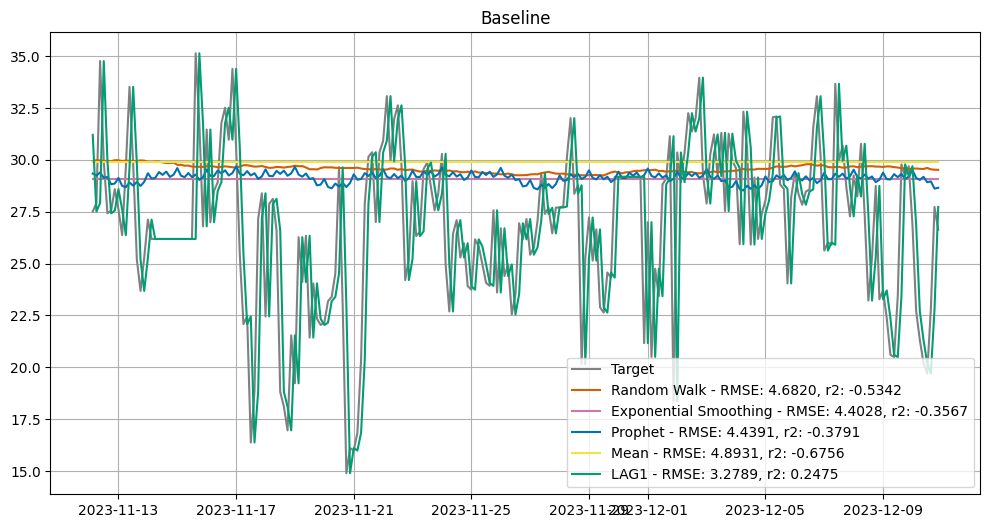

In [14]:
def plot_predictions(predictions, target, index, labels):
    plt.figure(figsize=(12, 6))
    
    colors = ['#d55e00', '#cc79a7', '#f0e442', '#009e73', '#ffffcc', '#e5d8bd', '#fddaec', '#f2f2f2', '#b3e2cd']

    # plt.plot(index, train.values)
    plt.plot(index, target, color='gray', label='Target')
    
    for i in range(len(predictions)):
        rmse = np.sqrt(mean_squared_error(target, predictions[i]))
        r2 = r2_score(target, predictions[i])
        plt.plot(index, predictions[i], label=f'{labels[i]} - RMSE: {rmse:.4f}, r2: {r2:.4f}', color=colors[i], linewidth=1.5)

    plt.title("Baseline")
    plt.legend()
    plt.grid()

predictions = [rw_pred[1:], ema_pred[1:], mean_pred[1:], lag_pred[1:]]
labels = ['Random Walk', 'Exponential Smoothing', 'Mean', 'LAG1']

plot_predictions(predictions, test[1:], test.index.values[1:], labels)

